In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data_train = pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/train.csv')
data_test = pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/test.csv')
oil = pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/oil.csv')
stores = pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/stores.csv')
holiday_events  =  pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/holidays_events.csv')
transactions = pd.read_csv('/content/drive/My Drive/Kaggle/Kaggle_store_sales/transactions.csv')

In [ ]:
# Check for missing values
print('Missing values in train:', data_train.isna().sum().sum())
print('Missing values in test:', data_test.isna().sum().sum())
print('Missing values in transactions:', transactions.isna().sum().sum())
print('Missing values in oil:', oil.isna().sum().sum())

data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])

Missing values in train: 0
Missing values in test: 0
Missing values in transactions: 0
Missing values in oil: 43


In [ ]:
import numpy as np
# Resample
oil = oil.set_index('date')['dcoilwtico'].resample('D').sum().reset_index()  # add missing dates and fill NaNs with 0 

# Interpolate
oil['dcoilwtico'] = np.where(oil['dcoilwtico']==0, np.nan, oil['dcoilwtico'])  # replace 0 with NaN
oil['dcoilwtico_interpolated'] = oil.dcoilwtico.interpolate() 

In [ ]:
temp = oil.melt(id_vars=['date'], var_name='Legend') 
px.line(temp.sort_values(['Legend', 'date'], ascending=[False, True]), x='date',y='value', color='Legend', title='Daily Oil Price')

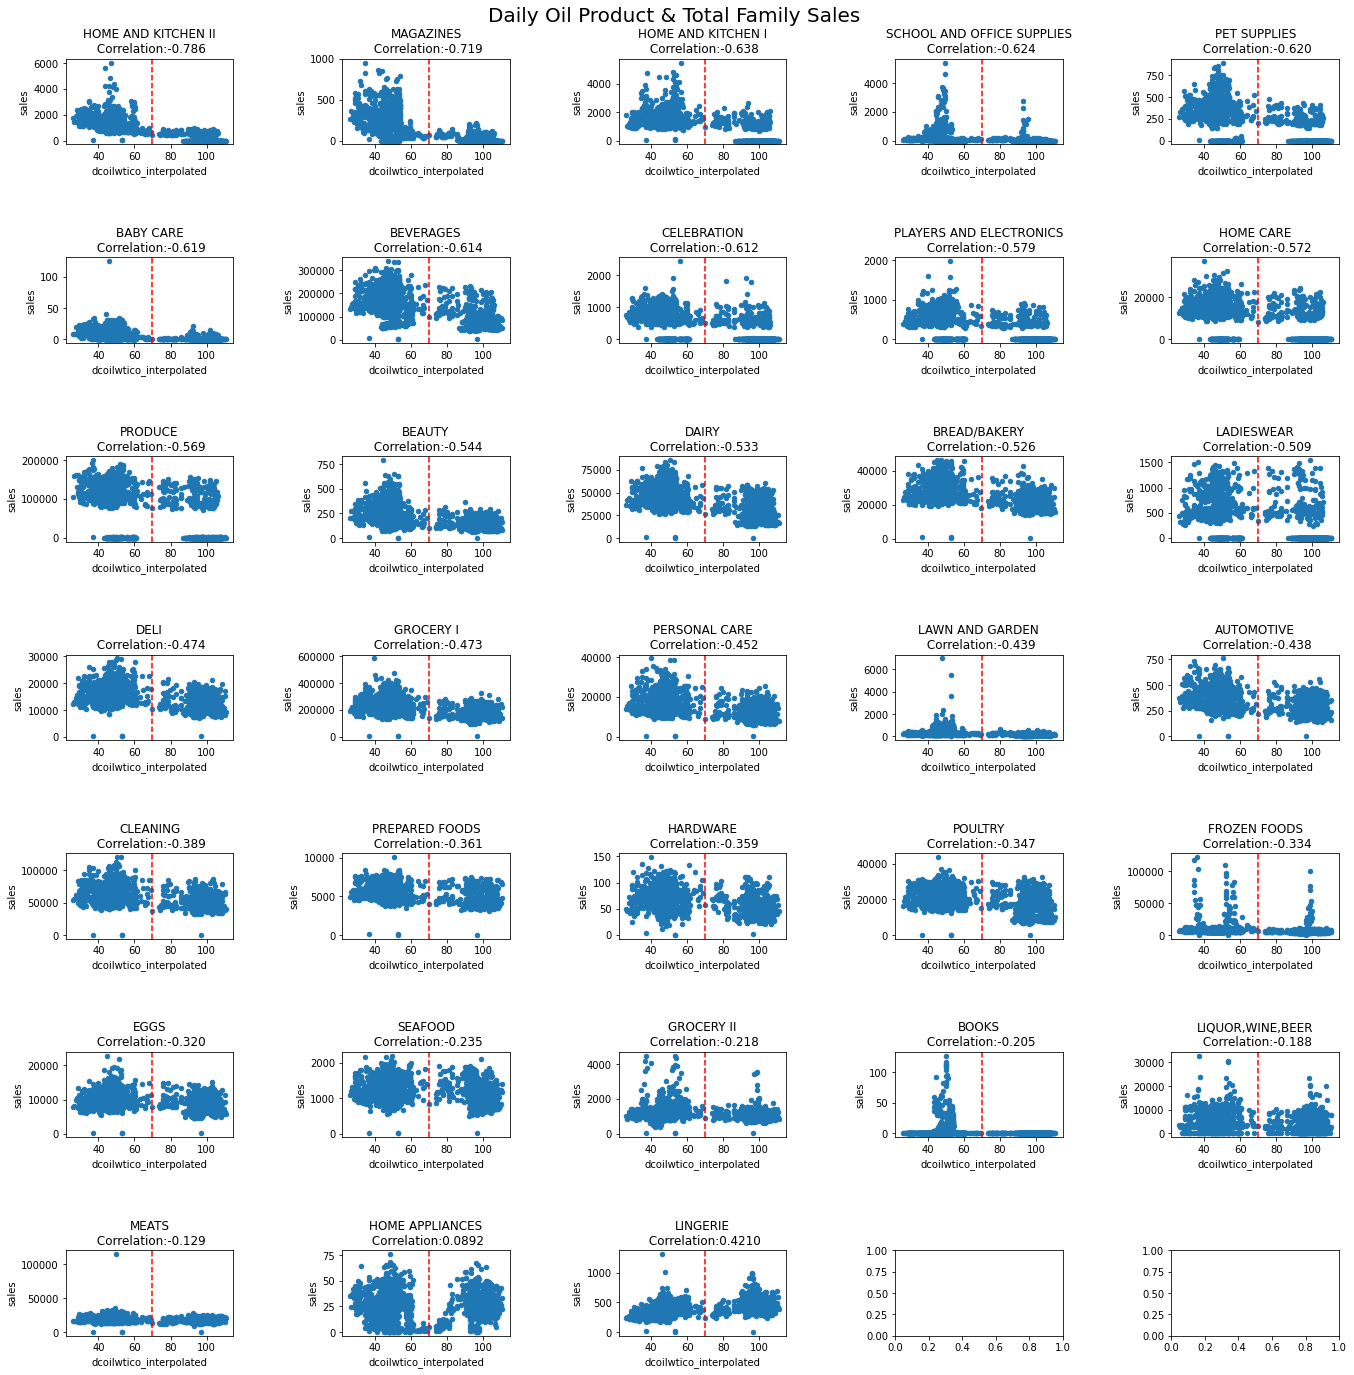

In [ ]:
import matplotlib.pyplot as plt

def plot_sales_and_oil_dependency():
    a = pd.merge(data_train.groupby(["date", "family"]).sales.sum().reset_index(),oil.drop("dcoilwtico", axis=1), how="left")
    c = a.groupby("family").corr("spearman").reset_index()
    c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")
    
    fig, axes = plt.subplots(7, 5, figsize=(20, 20))
    for i, fam in enumerate(c.family):
        a[a.family == fam].plot.scatter(x="dcoilwtico_interpolated", y="sales", ax=axes[i // 5, i % 5])
        axes[i // 5, i % 5].set_title(fam + "\n Correlation:" + str(c[c.family == fam].sales.iloc[0])[:6],fontsize=12)
        axes[i // 5, i % 5].axvline(x=70, color='r', linestyle='--')

    plt.tight_layout(pad=5)
    plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize=20)
    plt.show()

plot_sales_and_oil_dependency()

In [ ]:
##Add rolling mean of 7 days

oil_rdy = oil.loc[:, ['date', 'dcoilwtico_interpolated']]
oil_rdy.iloc[0, 1] = 93.1

assert oil_rdy.isna().sum().sum() == 0

oil_rdy['date'] = pd.to_datetime(oil_rdy['date'])
#oil_rdy['date'] = oil_rdy['date'].dt.to_period('D')
#oil_rdy = oil_rdy.set_index(['date'])

oil_rdy['rolling_mean_7'] = oil_rdy['dcoilwtico_interpolated'].rolling(7).mean()
oil_rdy.fillna(93.1, inplace=True)
#oil_rdy


In [ ]:
import plotly.express as px

data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])

temp_p = data_train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
px.line(temp_p, x='date', y='sales', color='store_nbr',title='Daily total sales of the stores')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
temp_p

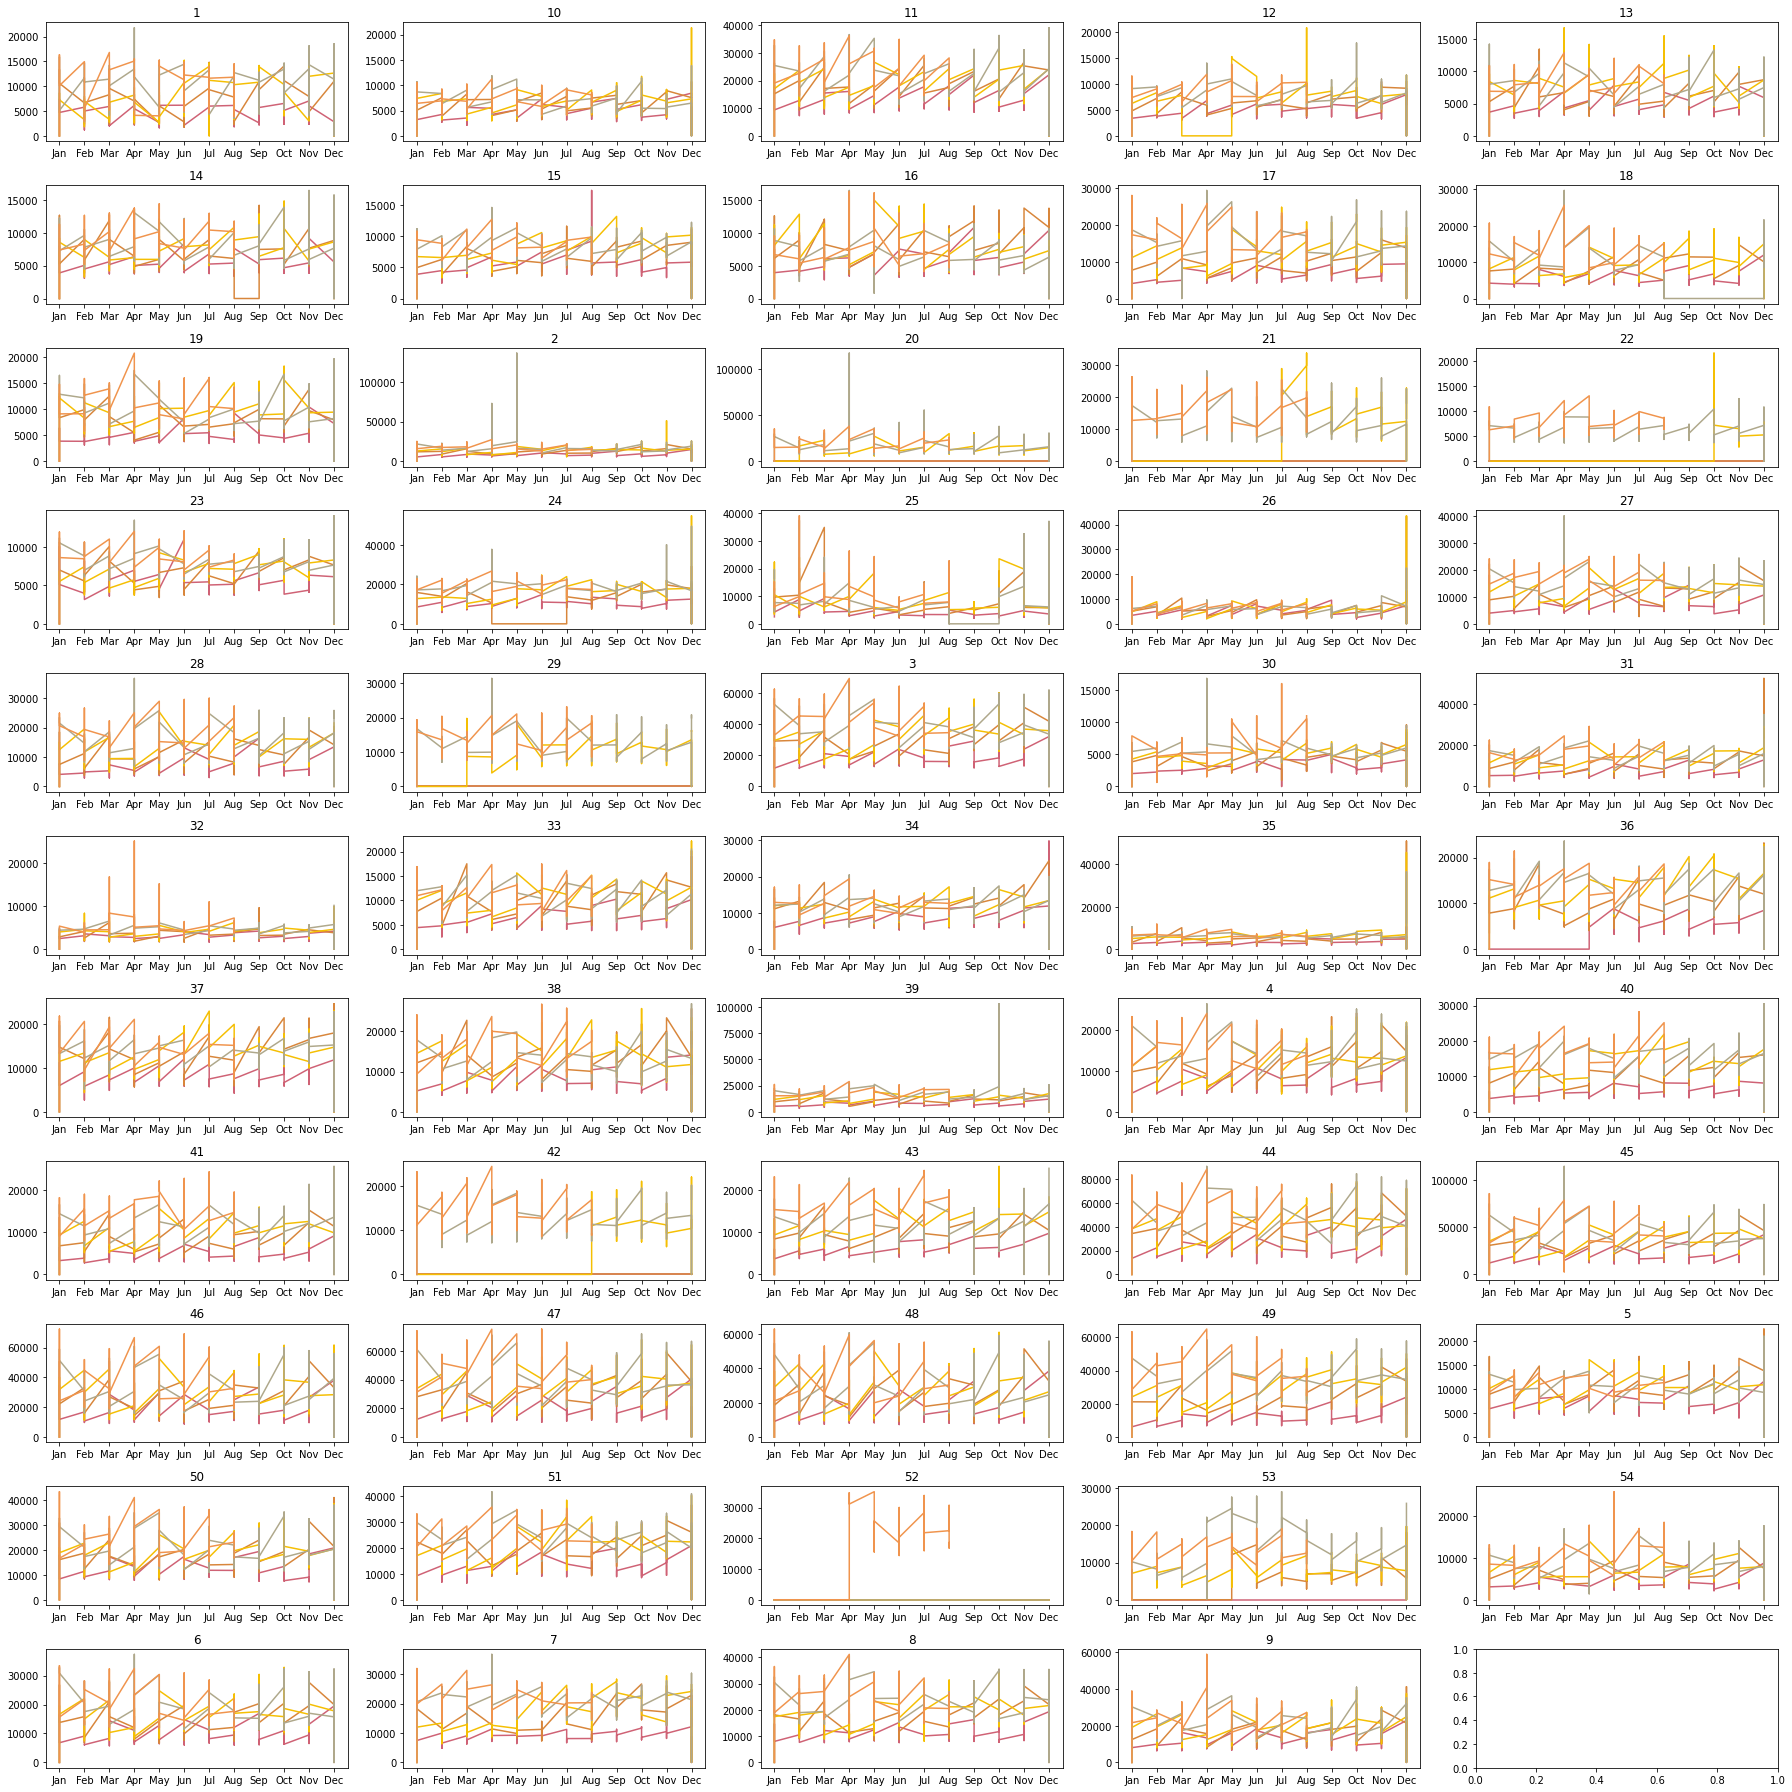

In [ ]:
### Seasonal plot of total sales

import matplotlib.pyplot as plt
import matplotlib as mpl

def seasonal_plot():
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p = data_train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
    temp_p['year'] = [d.year for d in temp_p.date]
    temp_p['month'] = [d.strftime('%b') for d in temp_p.date]    
    store = data_train['store_nbr'].unique()
    years = transactions['year'].unique()
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

    fig, axes = plt.subplots(11, 5, figsize=(25, 25))
   
    for i, fam in enumerate(store):
        temp =  temp_p.loc[temp_p['store_nbr'] == fam]
        for k, y in enumerate(years):
          axes[i // 5, i % 5].plot('month', 'sales', data=temp.loc[temp.year==y, :], label = y, color=mycolors[k])
          axes[i // 5, i % 5].set_title(fam,fontsize=12)

    plt.tight_layout()#(pad=5)
    plt.show()

seasonal_plot()



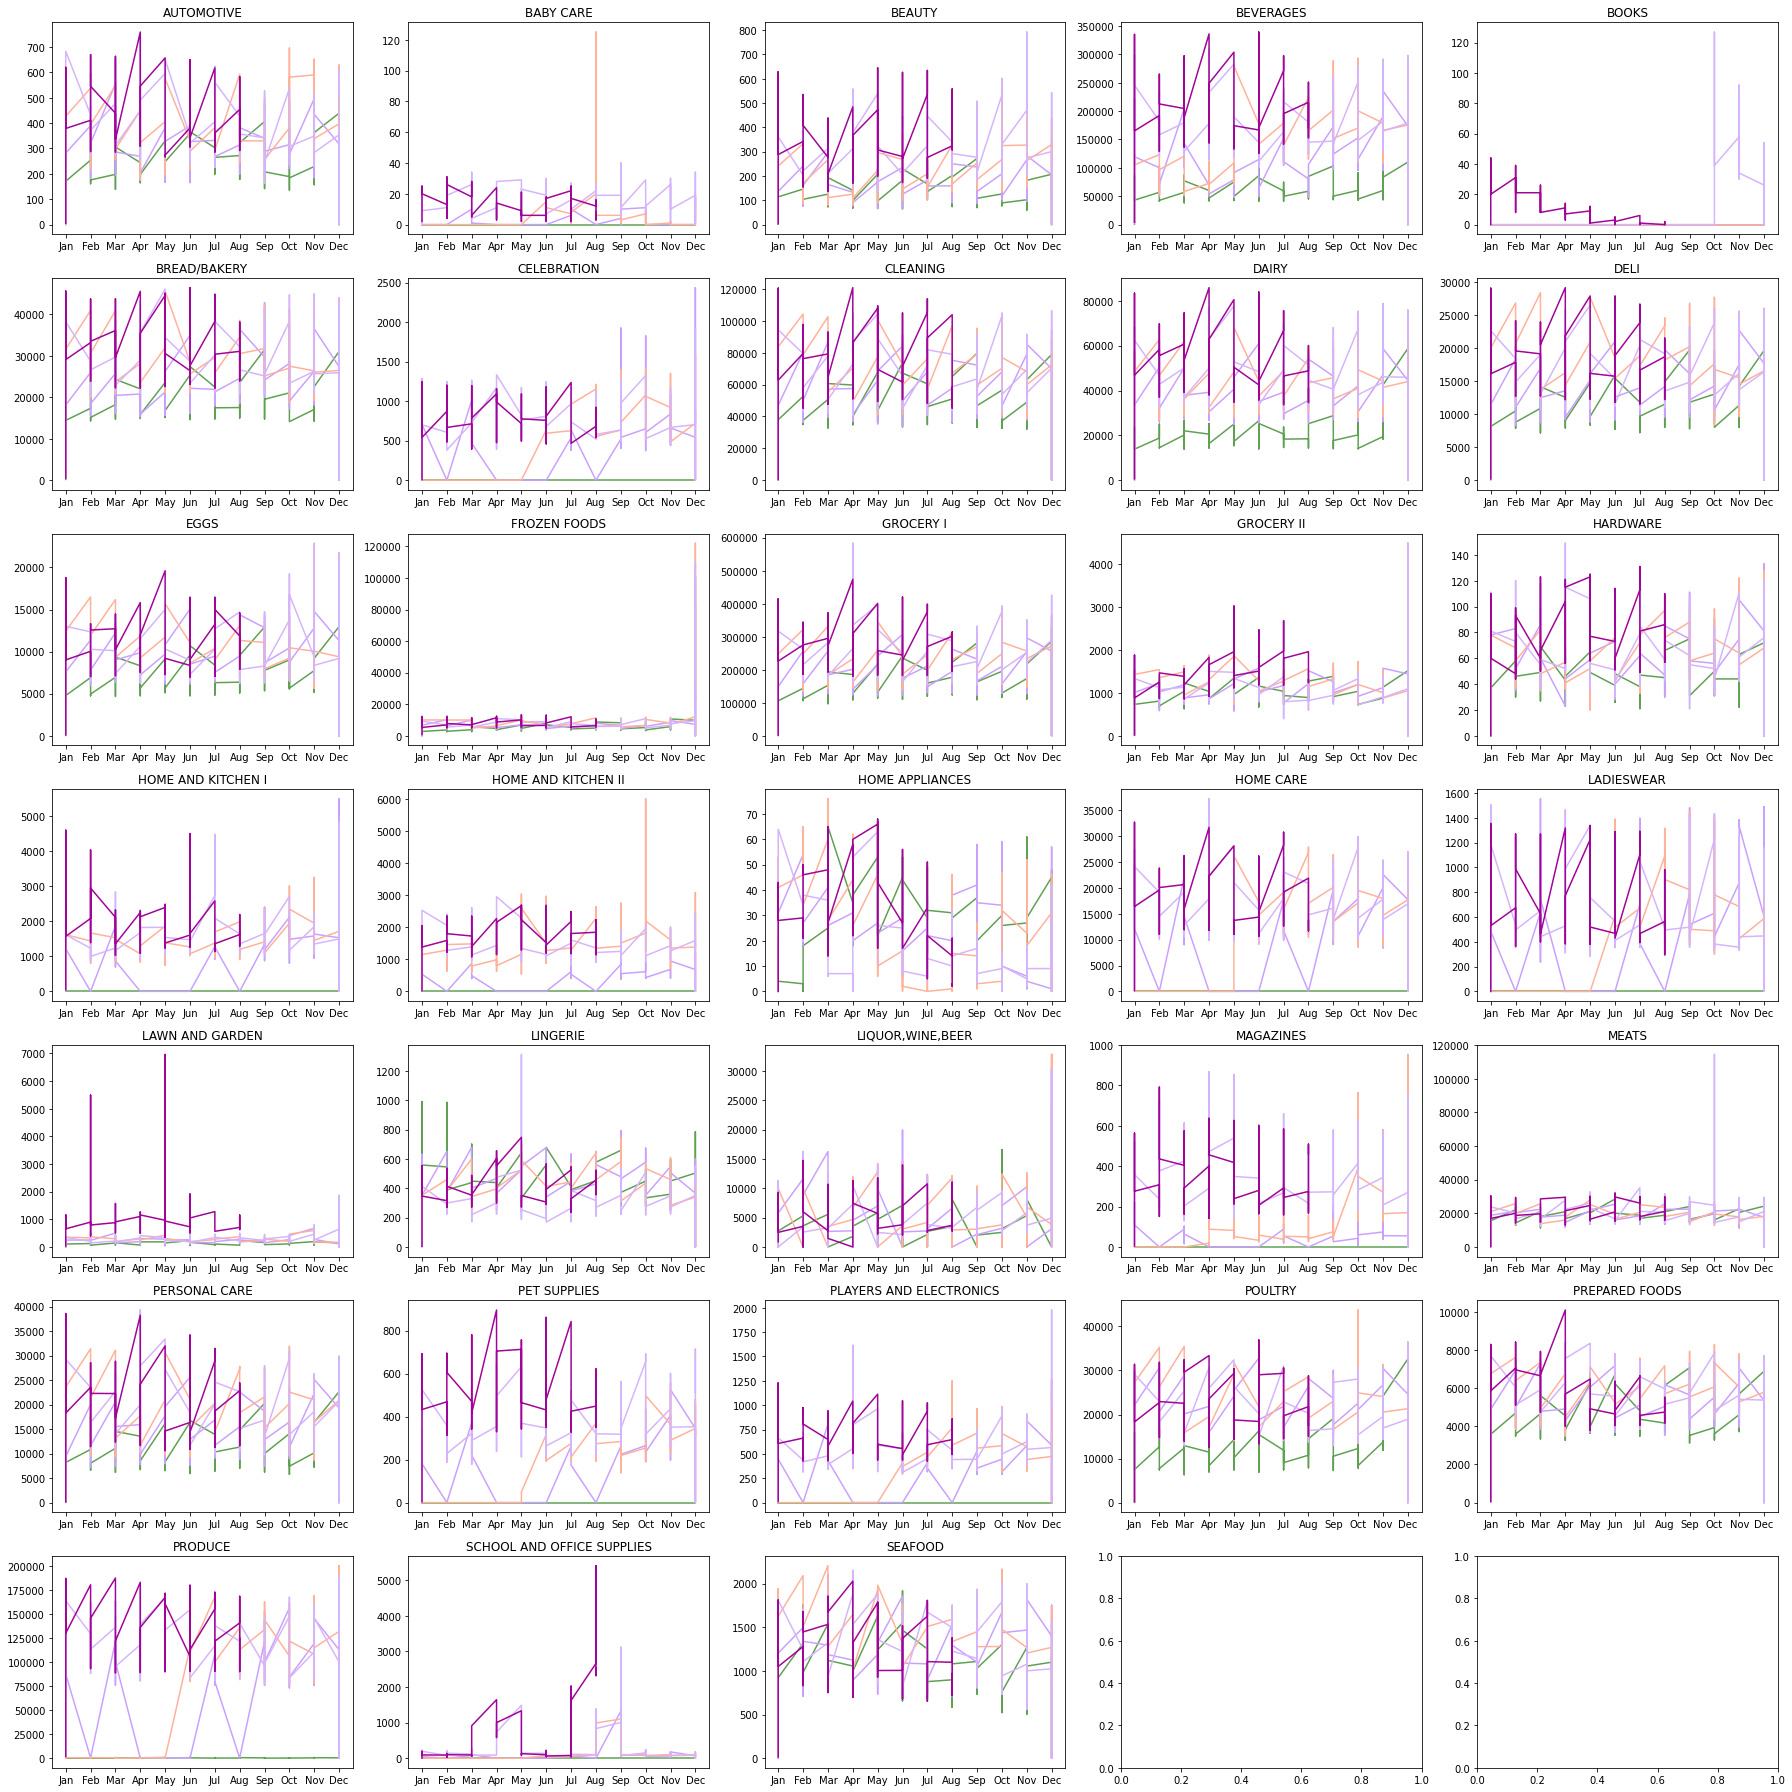

In [ ]:
### Seasonal plot of total sales per family

import matplotlib.pyplot as plt
import matplotlib as mpl

def seasonal_plot():
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p = data_train.set_index('date').groupby('family').resample('D').sales.sum().reset_index()
    temp_p['year'] = [d.year for d in temp_p.date]
    temp_p['month'] = [d.strftime('%b') for d in temp_p.date]    
    store = data_train['family'].unique()
    years = transactions['year'].unique()
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
    #print(len(store))
    fig, axes = plt.subplots(7, 5, figsize=(25, 25))
   
    for i, fam in enumerate(store):
        temp =  temp_p.loc[temp_p['family'] == fam]
        for k, y in enumerate(years):
          axes[i // 5, i % 5].plot('month', 'sales', data=temp.loc[temp.year==y, :], label = y, color=mycolors[k])
          axes[i // 5, i % 5].set_title(fam,fontsize=12)

    plt.tight_layout()#(pad=5)
    plt.show()

seasonal_plot()


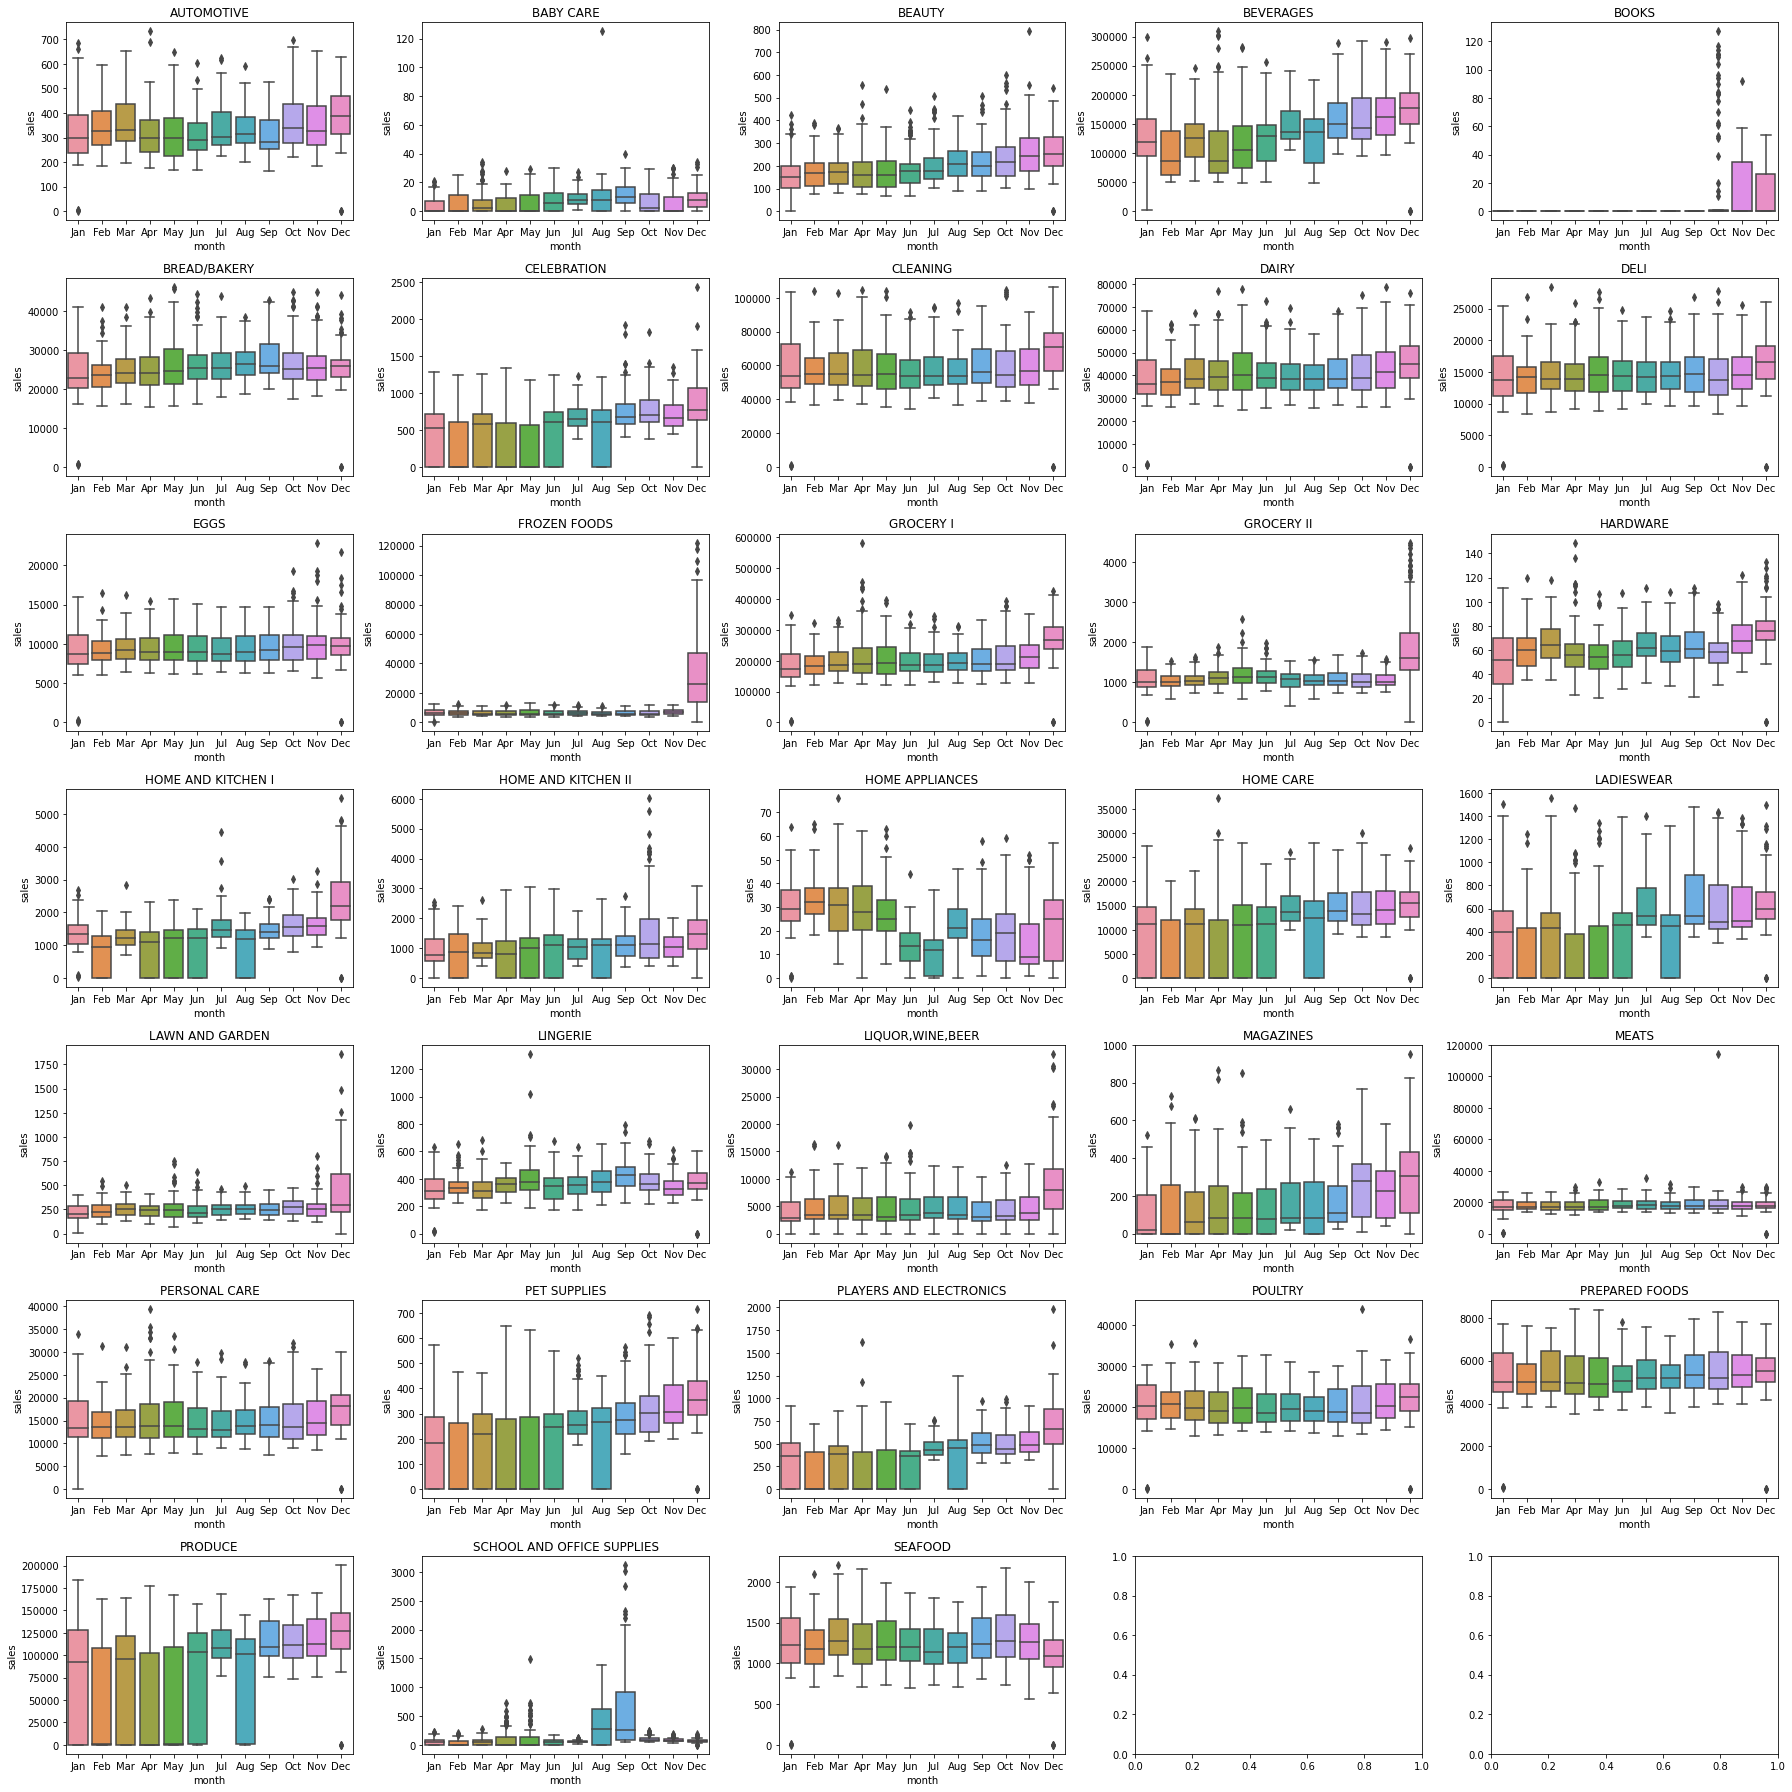

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def seasonal_plot():
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p = data_train.set_index('date').groupby('family').resample('D').sales.sum().reset_index()
    temp_p['year'] = [d.year for d in temp_p.date]
    temp_p['month'] = [d.strftime('%b') for d in temp_p.date]    
    store = data_train['family'].unique()
    years = transactions['year'].unique()
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
    #print(len(store))
    fig, axes = plt.subplots(7, 5, figsize=(25, 25))
   
    for i, fam in enumerate(store):
        temp =  temp_p.loc[temp_p['family'] == fam]
        sns.boxplot(ax =axes[i // 5, i % 5], x='month', y='sales', data=temp.loc[~temp.year.isin([2013, 2017]), :])
        axes[i // 5, i % 5].set_title(fam,fontsize=12)
      

    plt.tight_layout()#(pad=5)
    plt.show()

seasonal_plot()


In [ ]:
import numpy as np

df1 = pd.DataFrame(np.zeros(len(data_train)),columns=['holiday'])
data_train= pd.concat([data_train,df1], axis = 1)

#df1_cl = pd.DataFrame(np.zeros(len(data_train)),columns=['cluster'])
#df1_city = pd.DataFrame(np.zeros(len(data_train)),columns=['city'])
#df1_state = pd.DataFrame(np.zeros(len(data_train)),columns=['state'])
#data_train= pd.concat([data_train,df1,df1_cl, df1_city, df1_state], axis = 1)


In [ ]:
data_train = pd.merge_asof(data_train, transactions,on='date',by='store_nbr')

In [ ]:
data_train =pd.merge_asof(data_train, oil_rdy ,on='date')

In [ ]:
data_train = data_train.merge(stores)

In [ ]:
data_train['transactions'] = data_train['transactions'].fillna(0)

In [ ]:
import numpy as np

local_false = holiday_events.loc[(holiday_events['locale']=='Local')&(holiday_events['transferred']==False)]
national_false = holiday_events.loc[(holiday_events['locale']=='National')&(holiday_events['transferred']==False)]

len(local_false)

for i in range(0,len(local_false)):
  temp = np.where(data_train['date'] == local_false.iloc[i][0])[0]
  store_id = np.where(data_train['city'] == local_false.iloc[i][3])[0] +1
  intersect = np.intersect1d(temp, store_id)
  data_train['holiday'].loc[intersect] = 1.

for i in range(0,len(national_false)):
  temp = np.where(data_train['date'] == national_false.iloc[i][0])[0]
  data_train['holiday'].loc[temp] = 1.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data_train

id       date  store_nbr  ...      state  type  cluster
0              0 2013-01-01          1  ...  Pichincha     D       13
1              1 2013-01-01          1  ...  Pichincha     D       13
2              2 2013-01-01          1  ...  Pichincha     D       13
3              3 2013-01-01          1  ...  Pichincha     D       13
4              4 2013-01-01          1  ...  Pichincha     D       13
...          ...        ...        ...  ...        ...   ...      ...
3000883  3000883 2017-08-15          9  ...  Pichincha     B        6
3000884  3000884 2017-08-15          9  ...  Pichincha     B        6
3000885  3000885 2017-08-15          9  ...  Pichincha     B        6
3000886  3000886 2017-08-15          9  ...  Pichincha     B        6
3000887  3000887 2017-08-15          9  ...  Pichincha     B        6

[3000888 rows x 14 columns]

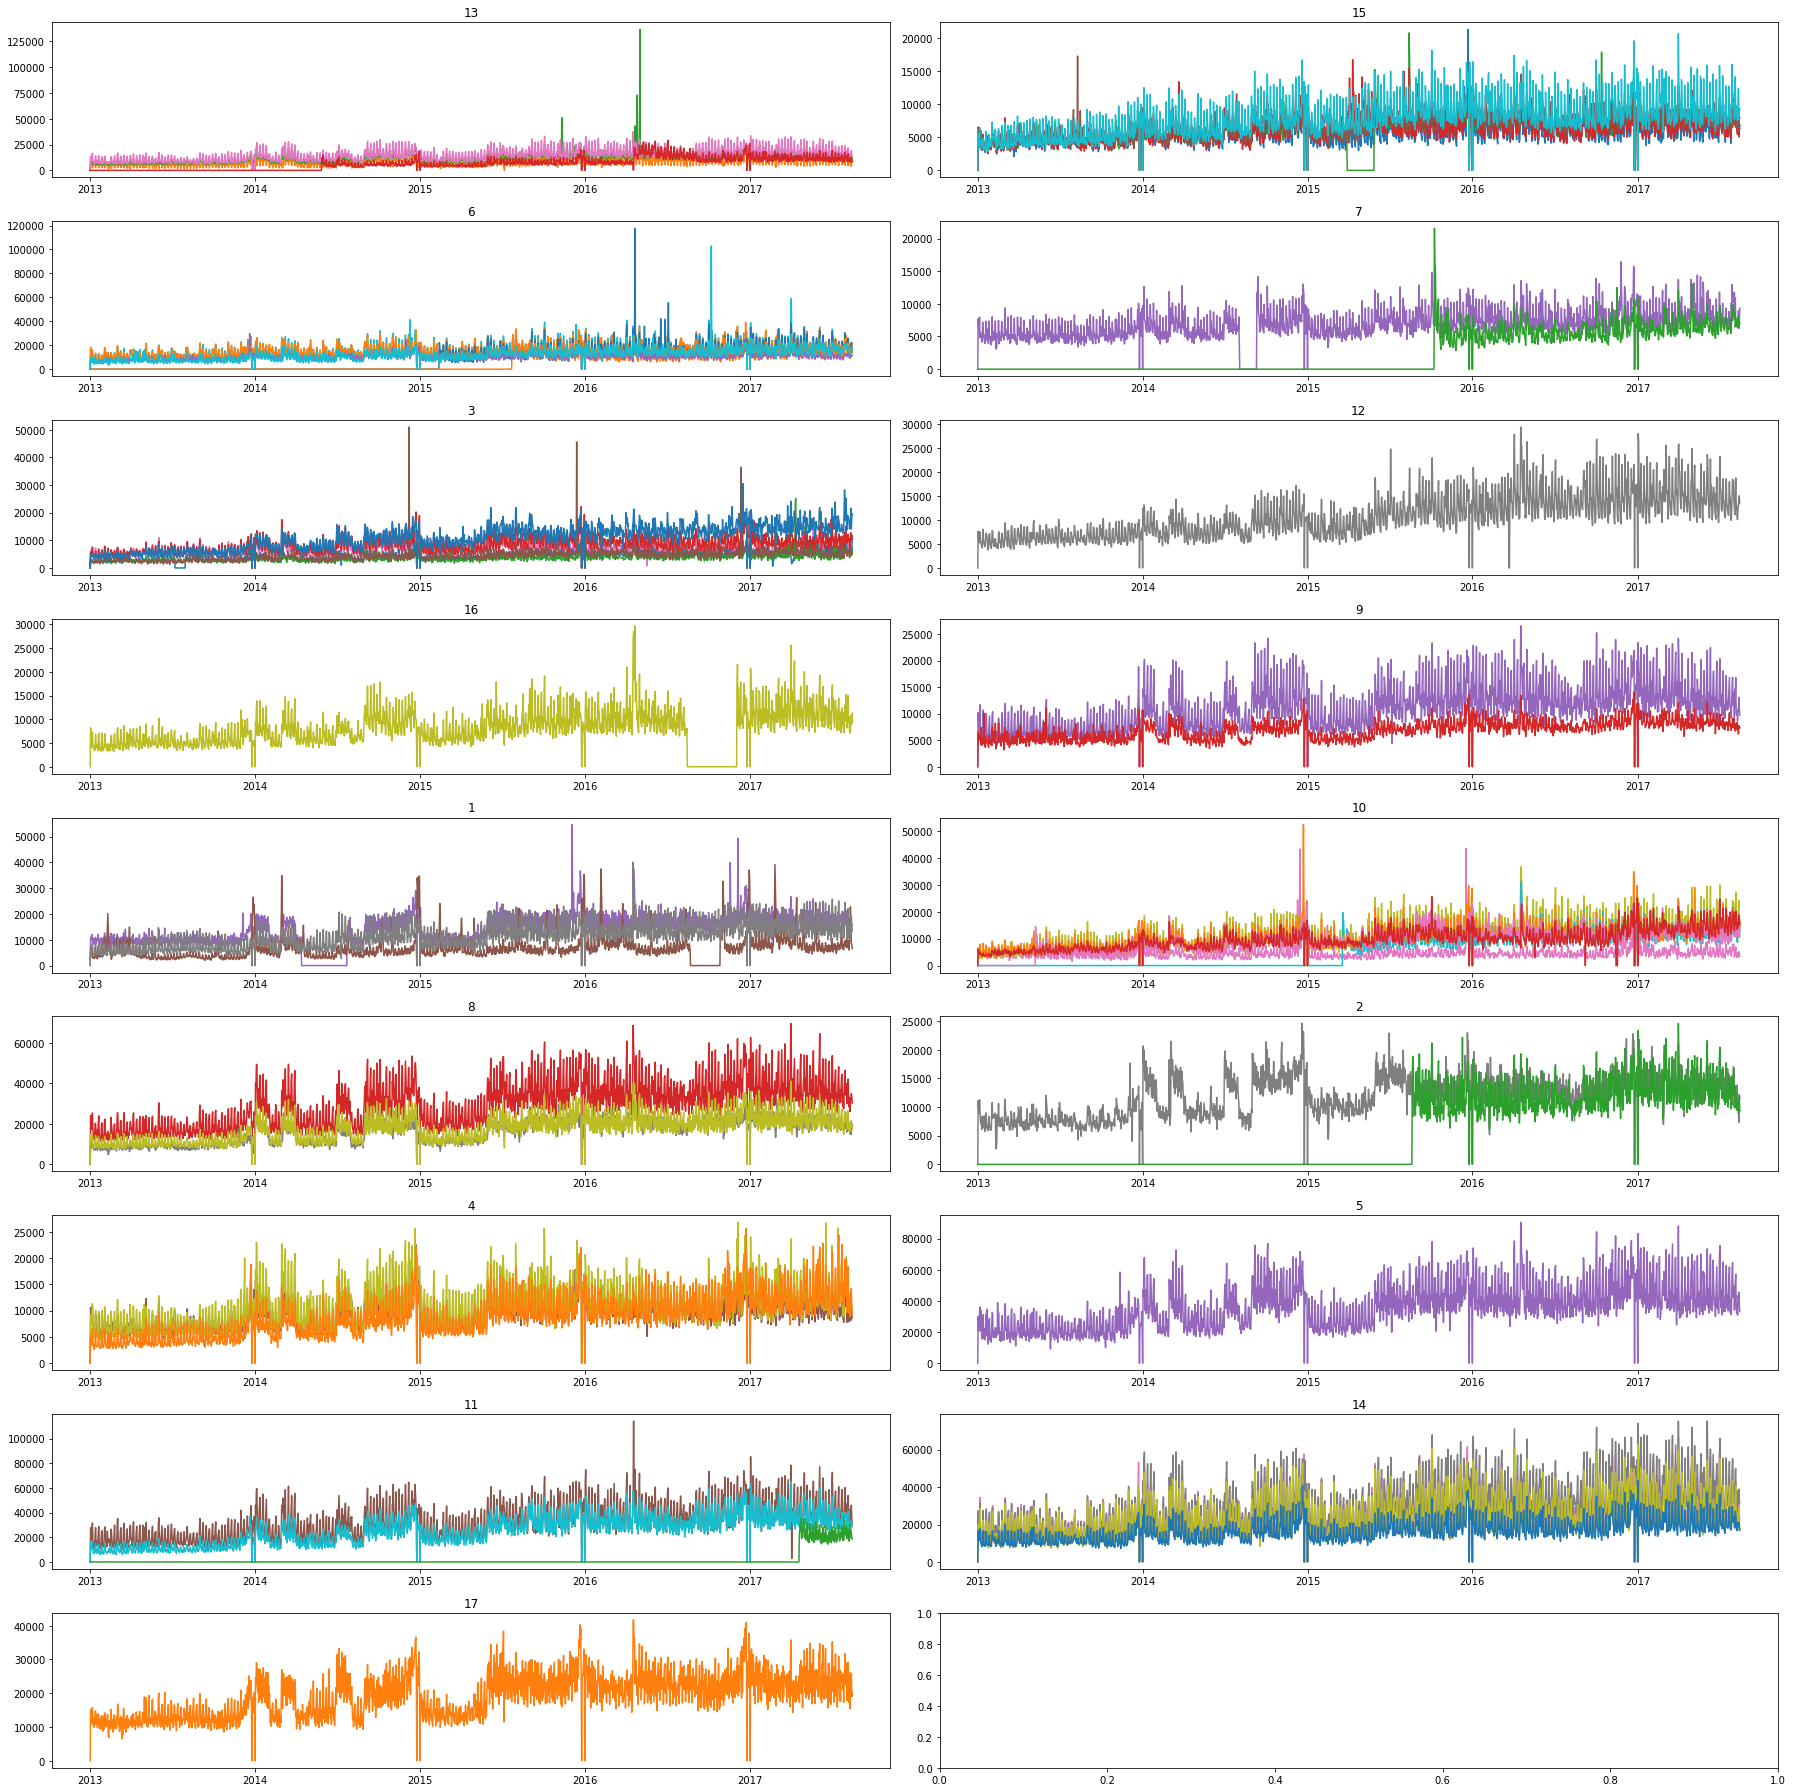

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def cluster_plot():
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p = data_train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
    temp_p = temp_p.merge(stores)
    store = data_train['store_nbr'].unique()
    cluster = data_train['cluster'].unique()
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(cluster), replace=False)
    fig, axes = plt.subplots(9, 2, figsize=(25, 25))
   
    for i, fam in enumerate(cluster):
        temp =  temp_p.loc[temp_p['cluster'] == fam]
        st = temp_p['store_nbr'].unique()
        for k, y in enumerate(st):
          axes[i // 2, i % 2].plot('date', 'sales', data=temp.loc[temp_p['store_nbr'] == k], label = y)#, color=mycolors[k])
          axes[i // 2, i % 2].set_title(fam,fontsize=12)

    plt.tight_layout()#(pad=5)
    plt.show()

cluster_plot()

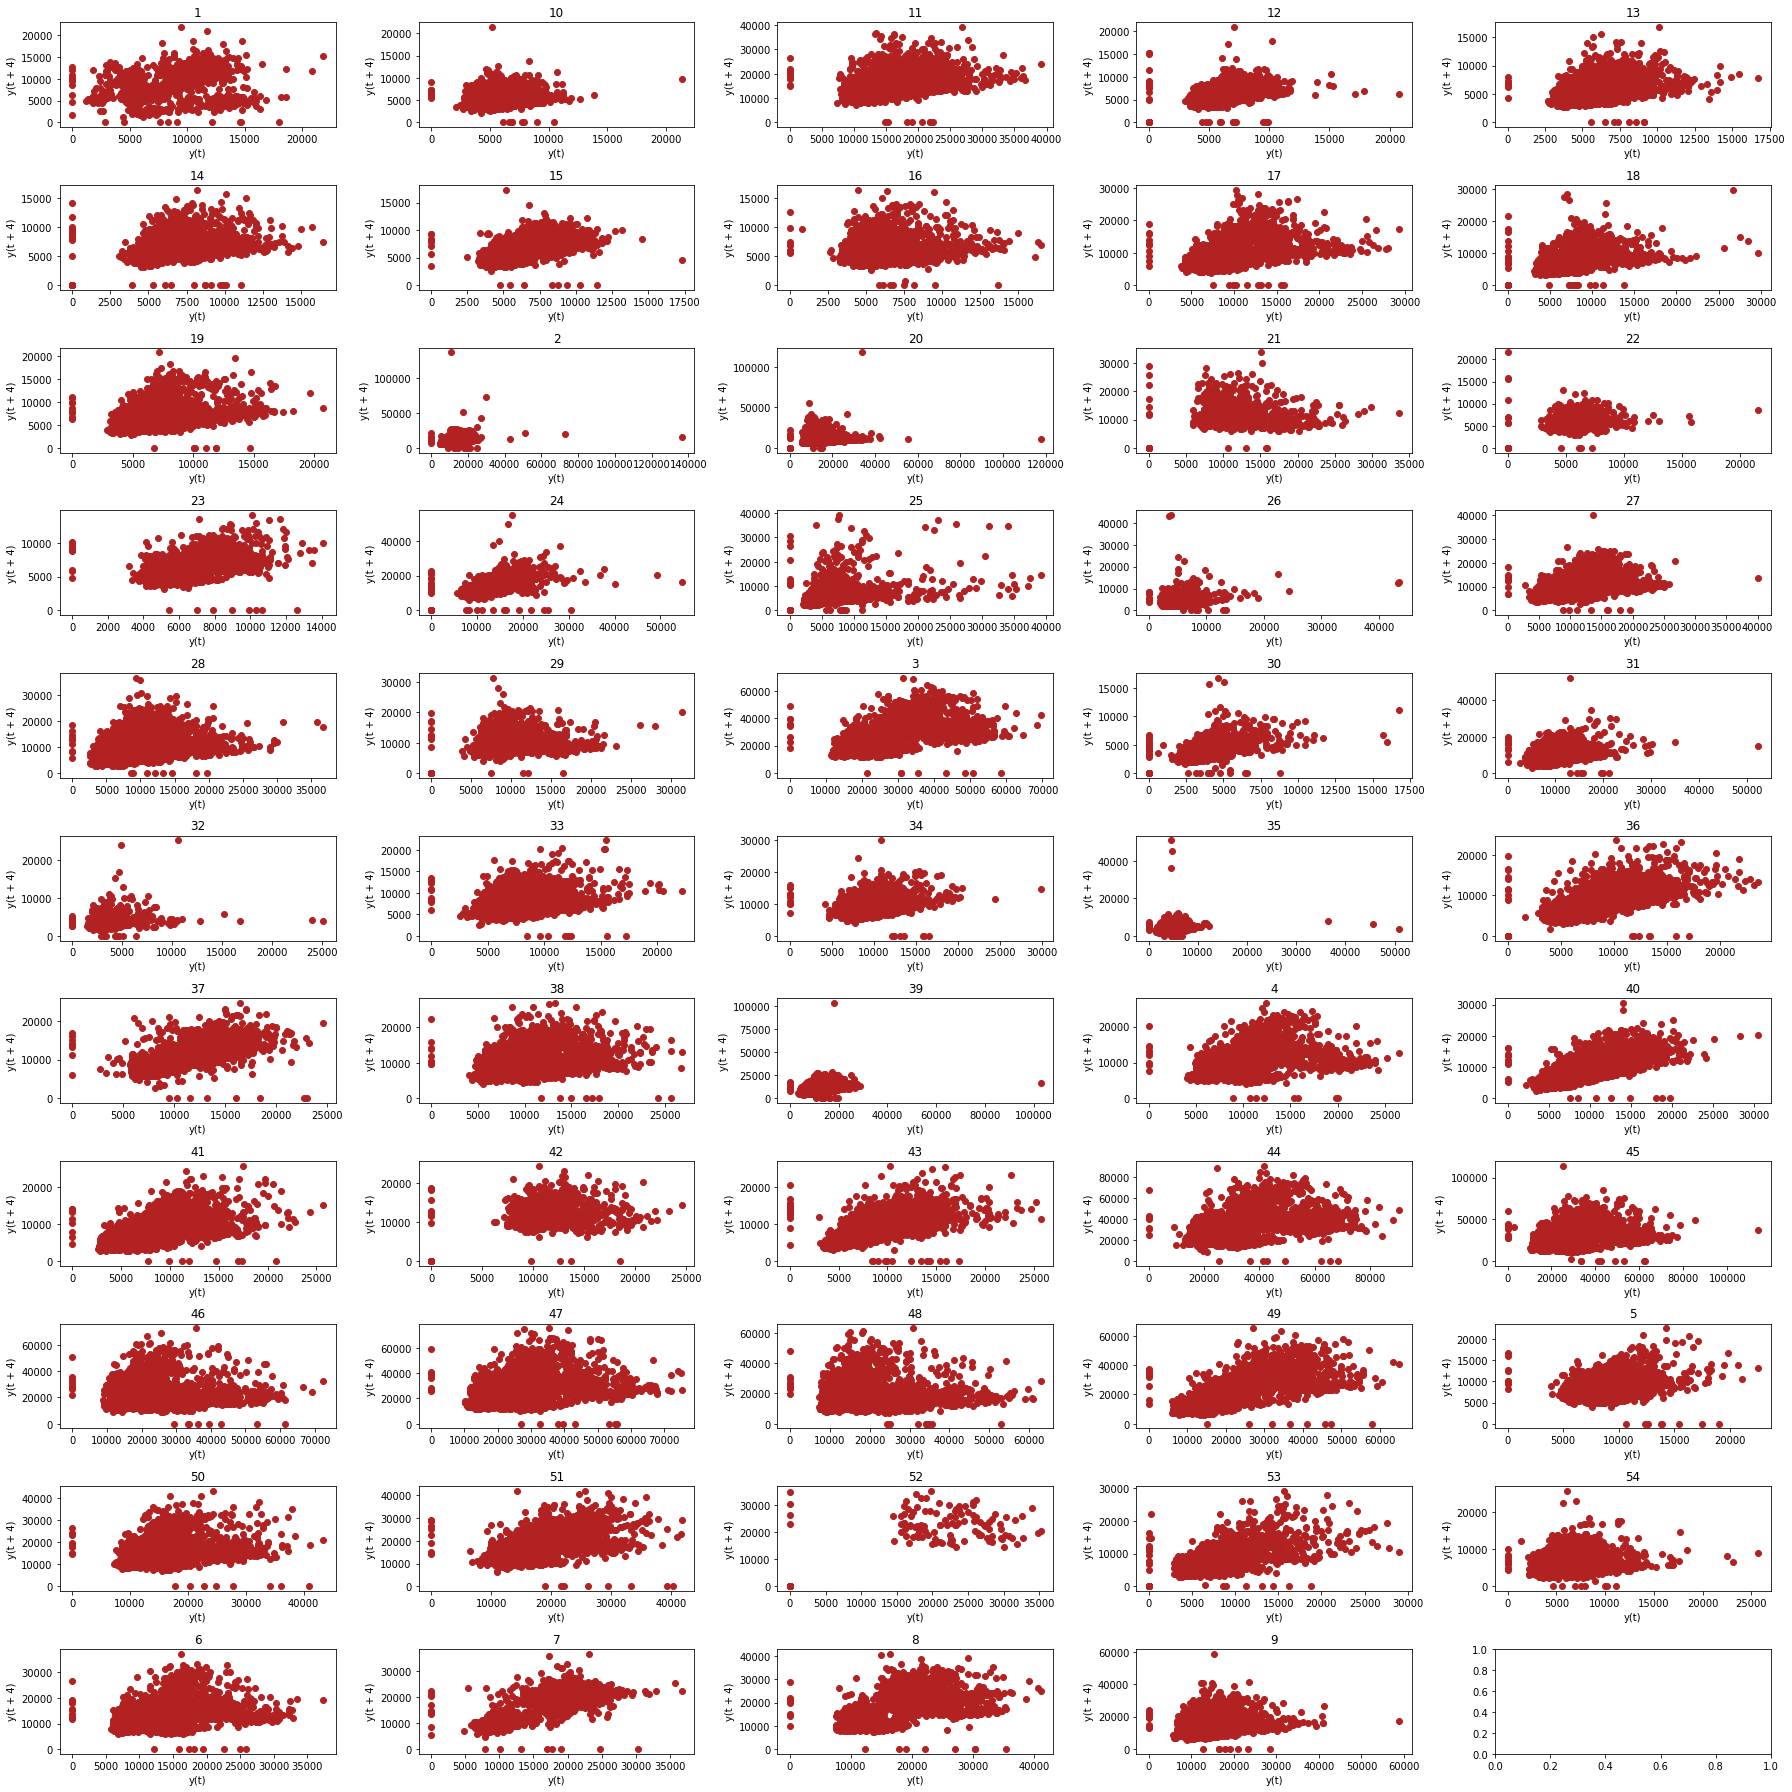

In [30]:
## checking for lag

from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_lag():
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p = data_train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index() 
    store = data_train['store_nbr'].unique()

    fig, axes = plt.subplots(11, 5, figsize=(25, 25))
   
    for i, fam in enumerate(store):
        temp =  temp_p.loc[temp_p['store_nbr'] == fam]
        lag_plot(temp.sales, lag=4, ax=axes[i // 5, i % 5], c='firebrick')
        axes[i // 5, i % 5].set_title(fam,fontsize=12)


    plt.tight_layout()#(pad=5)
    plt.show()

plot_lag()

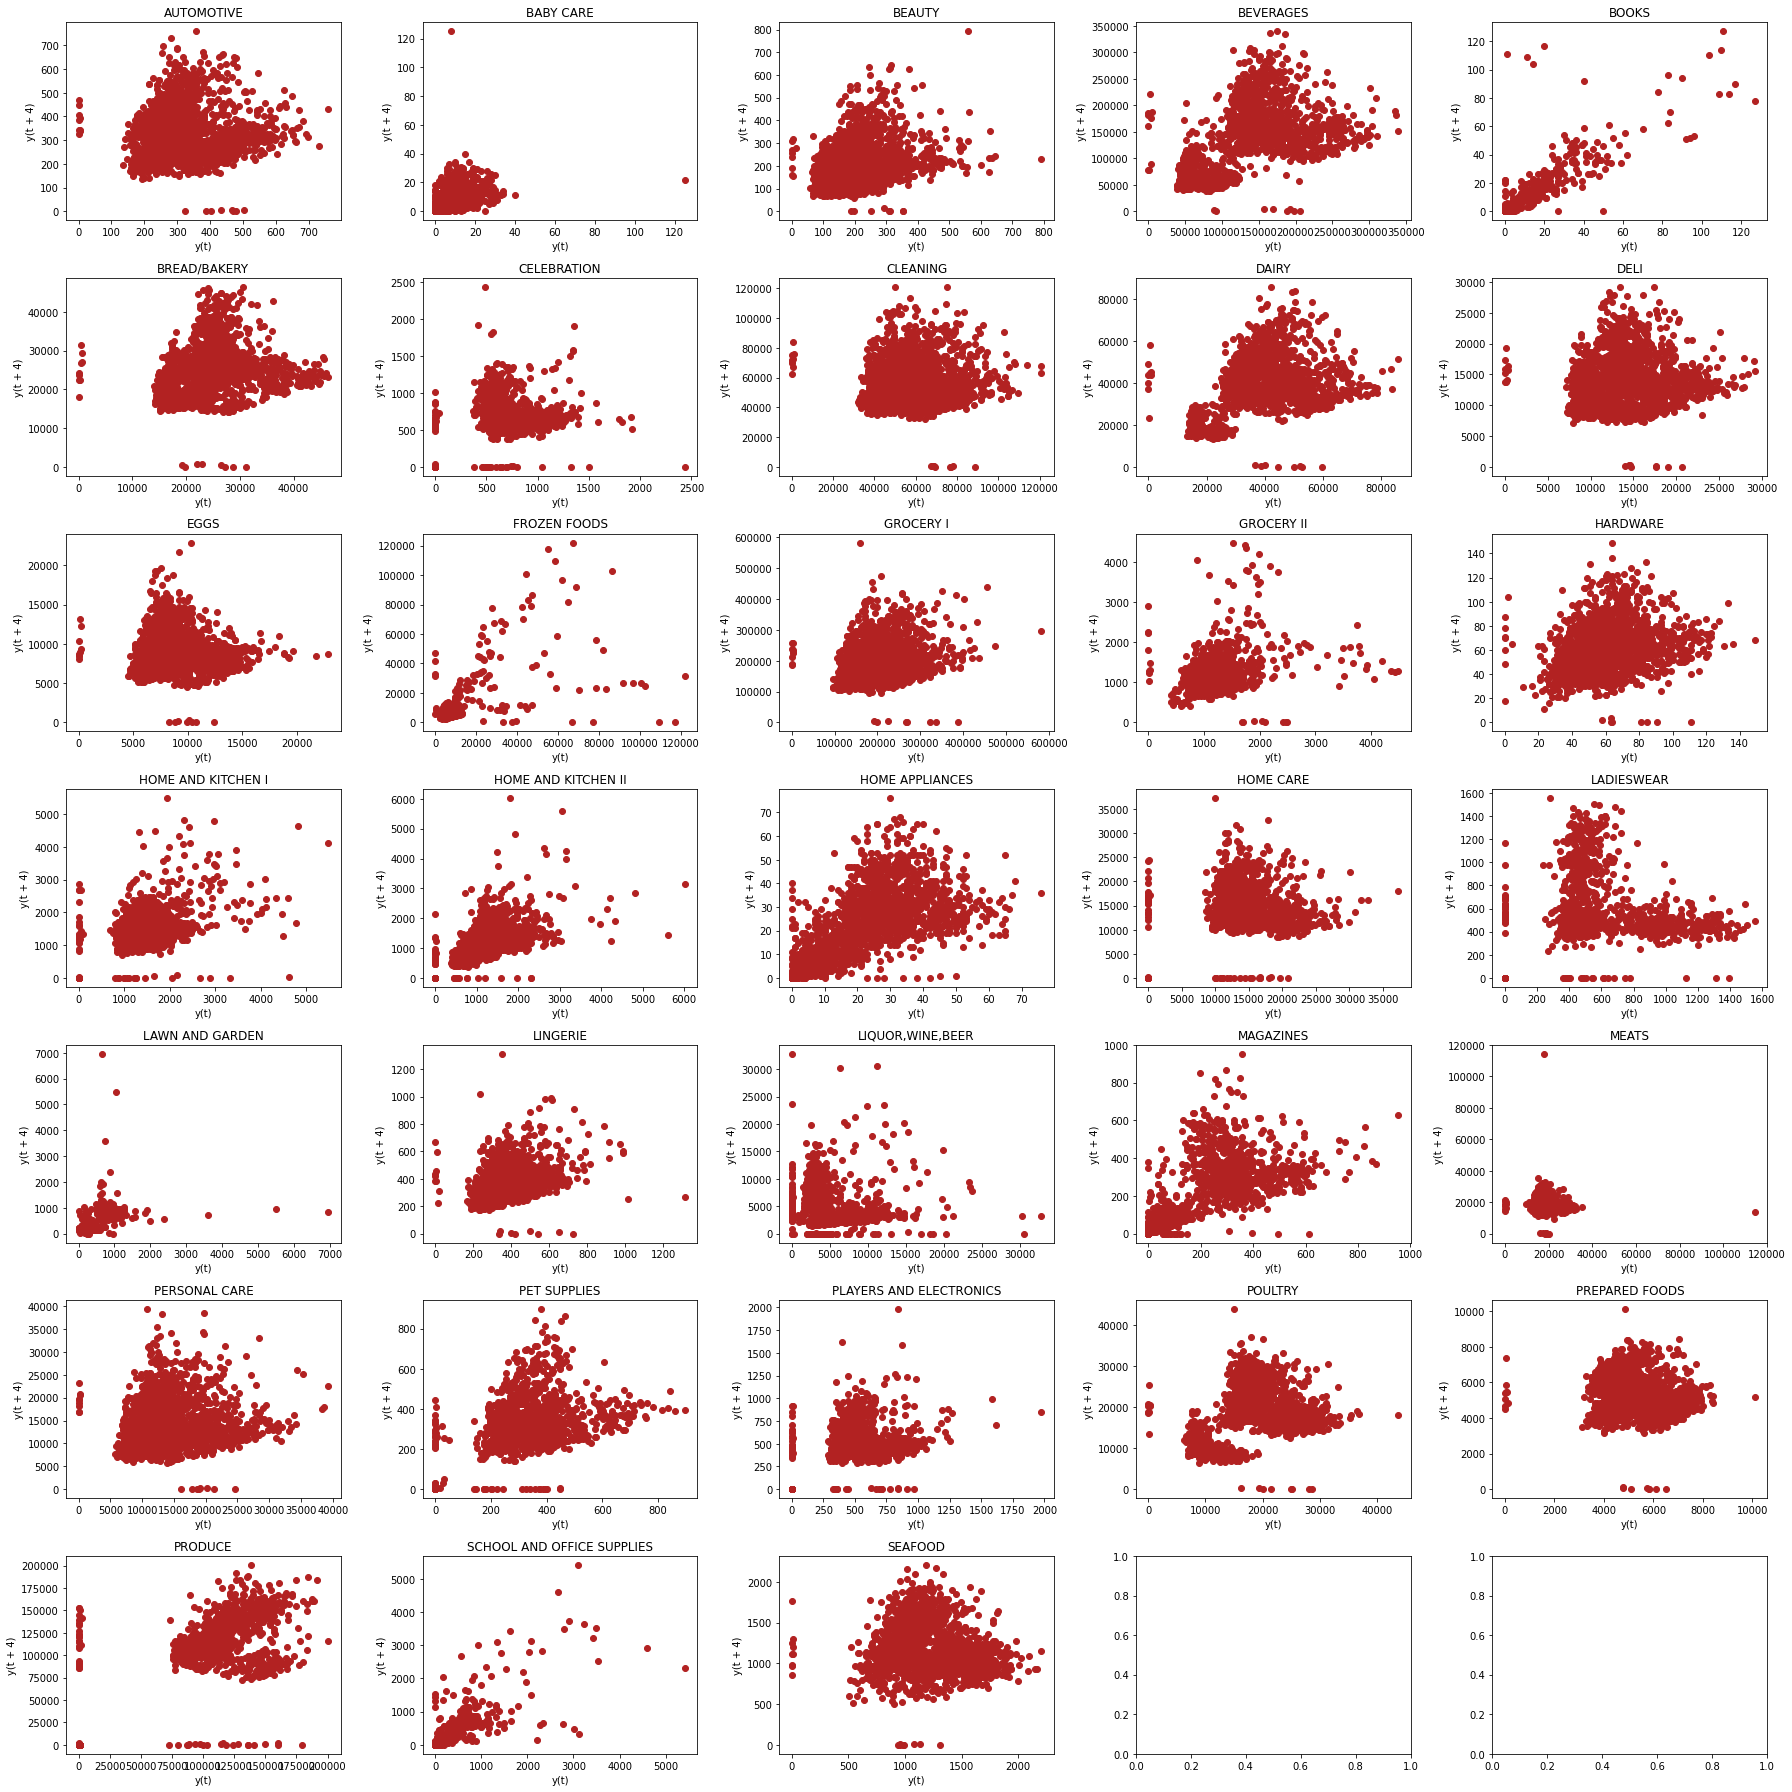

In [34]:
## checking for lag for each store

from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_lag(store_number):
    data_train['date'] = pd.to_datetime(data_train['date'])
    data_test['date'] = pd.to_datetime(data_test['date'])
    temp_p =  data_train.loc[data_train['store_nbr'] == store_number]
    temp_p = data_train.set_index('date').groupby('family').resample('D').sales.sum().reset_index() 
    store = data_train['family'].unique()

    fig, axes = plt.subplots(7, 5, figsize=(25, 25))
   
    for i, fam in enumerate(store):
        temp =  temp_p.loc[temp_p['family'] == fam]
        lag_plot(temp.sales, lag=4, ax=axes[i // 5, i % 5], c='firebrick')
        axes[i // 5, i % 5].set_title(fam,fontsize=12)


    plt.tight_layout()#(pad=5)
    plt.show()

plot_lag(12)

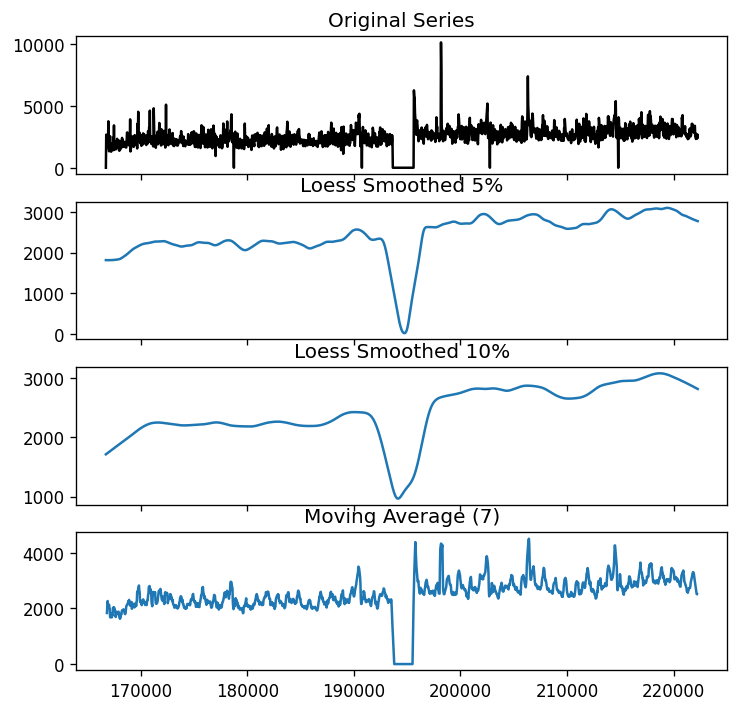

In [40]:
### smoothen the timeseries data example for one store, one family

from statsmodels.nonparametric.smoothers_lowess import lowess

store1 = data_train.loc[data_train['store_nbr'] == 12]
nn = store1.loc[store1['family'] == 'GROCERY I']

# 1. Moving Average
df_ma = nn.sales.rolling(7, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(nn.sales, np.arange(len(nn.sales)), frac=0.05)[:, 1], index=nn.index, columns=['sales'])
df_loess_10 = pd.DataFrame(lowess(nn.sales, np.arange(len(nn.sales)), frac=0.1)[:, 1], index=nn.index, columns=['sales'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
nn['sales'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['sales'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_10['sales'].plot(ax=axes[2], title='Loess Smoothed 10%')
df_ma.plot(ax=axes[3], title='Moving Average (7)')
plt.show()

In [47]:
import plotly.express as px

#temp_p = data_train.set_index('date').groupby('store_nbr').resample('D').sales.sum().reset_index()
store1 = data_train.loc[data_train['store_nbr'] == 12]
nn = store1.loc[store1['family'] == 'POULTRY']

px.line(nn, x='date', y='sales', color='store_nbr',title='Daily total sales of the stores')

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
store1 = data_train.loc[data_train['store_nbr'] == 12]
nn = store1.loc[store1['family'] == 'GROCERY I']
acf_50 = acf(nn.sales, nlags=50)
print(acf_50)

[1.         0.69308457 0.55529358 0.46428753 0.43198106 0.44532709
 0.47707604 0.49995101 0.46120516 0.40231664 0.35098107 0.36233836
 0.38130911 0.43508702 0.47403508 0.4232761  0.36571459 0.32115939
 0.3111513  0.34051925 0.36878857 0.40034816 0.36065201 0.29196847
 0.25237051 0.24839595 0.27820114 0.3373202  0.37992907 0.3408225
 0.30249307 0.24637187 0.24080175 0.26837839 0.29353243 0.31760243
 0.25105606 0.1990213  0.15784391 0.15977469 0.18716798 0.23460043
 0.25881077 0.22197715 0.17414587 0.12874111 0.13669908 0.16777157
 0.20939063 0.22593118 0.19675099]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Data cleanup DONE!

In [ ]:
features = ['date','family','sales','onpromotion','holiday','transactions', 'rolling_mean_7']
features = ['onpromotion','holiday','transactions', 'rolling_mean_7']
features = ['onpromotion','transactions', 'rolling_mean_7']

In [ ]:
store1 = data_train.loc[data_train['store_nbr'] == 12]

In [ ]:
store1

id       date  store_nbr  ...     state  type  cluster
166716       99 2013-01-01         12  ...  Cotopaxi     C       15
166717      100 2013-01-01         12  ...  Cotopaxi     C       15
166718      101 2013-01-01         12  ...  Cotopaxi     C       15
166719      102 2013-01-01         12  ...  Cotopaxi     C       15
166720      103 2013-01-01         12  ...  Cotopaxi     C       15
...         ...        ...        ...  ...       ...   ...      ...
222283  2999233 2017-08-15         12  ...  Cotopaxi     C       15
222284  2999234 2017-08-15         12  ...  Cotopaxi     C       15
222285  2999235 2017-08-15         12  ...  Cotopaxi     C       15
222286  2999236 2017-08-15         12  ...  Cotopaxi     C       15
222287  2999237 2017-08-15         12  ...  Cotopaxi     C       15

[55572 rows x 14 columns]

In [ ]:
nn = store1.loc[store1['family'] == 'GROCERY I']
pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(nn['date'])
#https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [ ]:
nn

id       date  store_nbr  ...     state  type  cluster
166728      111 2013-01-01         12  ...  Cotopaxi     C       15
166761     1893 2013-01-02         12  ...  Cotopaxi     C       15
166794     3675 2013-01-03         12  ...  Cotopaxi     C       15
166827     5457 2013-01-04         12  ...  Cotopaxi     C       15
166860     7239 2013-01-05         12  ...  Cotopaxi     C       15
...         ...        ...        ...  ...       ...   ...      ...
222135  2992089 2017-08-11         12  ...  Cotopaxi     C       15
222168  2993871 2017-08-12         12  ...  Cotopaxi     C       15
222201  2995653 2017-08-13         12  ...  Cotopaxi     C       15
222234  2997435 2017-08-14         12  ...  Cotopaxi     C       15
222267  2999217 2017-08-15         12  ...  Cotopaxi     C       15

[1684 rows x 14 columns]

In [ ]:
un = np.unique(data_train['family'])

for i in range(1,len(un)):
  nn = pd.concat([nn, store1.loc[store1['family'] == str(un[i])]])
#pd.concat([nn,nn])

In [ ]:
from sklearn.preprocessing import StandardScaler

arr_1 = nn[features].to_numpy()
arr_2 = nn['sales'].to_numpy()
print(arr_1.shape, arr_2.shape)

scaler = StandardScaler()
arr_1_sc= scaler.fit_transform(arr_1)

X = np.array(arr_1_sc).reshape(len(un), 1684, len(features))
Y = np.array(arr_2).reshape(len(un), 1684, 1)

print(X.shape, Y.shape)

(55572, 3) (55572,)
(33, 1684, 3) (33, 1684, 1)


In [ ]:
X

In [ ]:
X[:,1348:1684,:].shape

(33, 336, 4)

In [ ]:
#split into 80:20 testing and training

X_train = X[:,:1348,:]
Y_train = Y[:,:1348,:]
X_test = X[:,1348:1684,:]
Y_test = Y[:,1348:1684,:]
print(X_train.shape,  Y_train.shape, X_test.shape)

(33, 1348, 4) (33, 1348, 1) (33, 336, 4)


In [ ]:
##One to One LSTM wth one feature

test_o = store1.loc[store1['family'] == 'GROCERY I']
arr_2_o = test_o['sales'].to_numpy()
X = np.array([x+1 for x in range(len(arr_2_o))])
X = X.reshape(len(arr_2_o), 1, 1)
print(X.shape, arr_2_o.shape)

from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
import tensorflow as tf


model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

history = model.fit(X, arr_2_o, epochs=100, validation_split=0.2, verbose=1)

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

test_o = store1.loc[store1['family'] == 'GROCERY I']
arr_2_o = test_o['sales'].to_numpy()

print(arr_2_o.shape)

Y_train = arr_2_o[:1348]
Y_test = arr_2_o[1348:1684]

print(Y_train.shape, Y_test.shape)

model = auto_arima(Y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(Y_train)

forecast = model.predict(n_periods=len(Y_test))
#forecast = pd.DataFrame(forecast,index = Y_test.index,columns=['Prediction'])

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(Y_test,forecast))
print("RMSE: ", rms)

RMSE:  647.1431351036567


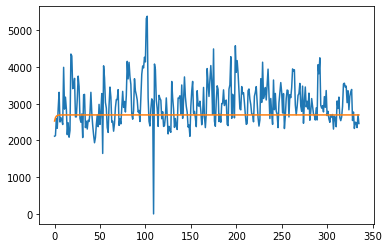

In [ ]:
import matplotlib.pyplot as plt


plt.plot(np.arange(len(Y_test)), Y_test)
plt.plot(np.arange(len(forecast)), forecast)

plt.show()

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

test_o = store1.loc[store1['family'] == 'GROCERY I']

arr_1_o = test_o[features].to_numpy()
arr_2_o = test_o['sales'].to_numpy()
print(arr_1_o.shape, arr_2_o.shape)

scaler = StandardScaler()
arr_1_sc_o= scaler.fit_transform(arr_1_o)

X = arr_1_sc_o.reshape(1684, 1, len(features))

print(X.shape)
print(arr_2_o)
#model = Sequential()
#model.add(LSTM(100, input_shape=(1,4)))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, len(features))))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(250, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])#, metrics = [tf.keras.metrics.acc(name='acc')])

history = model.fit(X, arr_2_o, epochs=100, validation_split=0.2, verbose=1)

(1684, 3) (1684,)
(1684, 1, 3)
[   0. 2677. 2006. ... 2350. 2702. 2461.]
Epoch 1/100
43/43 [==============================] - 6s 32ms/step - loss: 6344598.5000 - mse: 6344598.5000 - val_loss: 9229615.0000 - val_mse: 9229615.0000
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 4803848.0000 - mse: 4803848.0000 - val_loss: 5389128.5000 - val_mse: 5389128.5000
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 832580.0625 - mse: 832580.0625 - val_loss: 897169.0625 - val_mse: 897169.0625
Epoch 4/100
43/43 [==============================] - 1s 18ms/step - loss: 510054.4375 - mse: 510054.4375 - val_loss: 900537.7500 - val_mse: 900537.7500
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 435754.4375 - mse: 435754.4375 - val_loss: 870154.0625 - val_mse: 870154.0625
Epoch 6/100
43/43 [==============================] - 1s 18ms/step - loss: 407861.9688 - mse: 407861.9688 - val_loss: 817950.7500 - val_mse: 817950.7500
Epoch 7

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM

#model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(1348, 4)))
#model.add(RepeatVector(1348))
#model.add(LSTM(50, activation='relu', return_sequences=True))
#model.add(TimeDistributed(Dense(1)))
#model.compile(optimizer='adam', loss='mse')

#model = Sequential()
#model.add(LSTM(100, input_shape=(1348, 4)))
#model.add(RepeatVector(1348))
#model.add(LSTM(100, return_sequences=True)) 
##model.add(Dense(1, activation='softmax'))
#model.add(TimeDistributed(Dense(1)))
#model.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(LSTM(100, input_shape=(1348, 4)))
model.add(RepeatVector(1348))
model.add(LSTM(200, return_sequences=True)) 
model.add(LSTM(200, return_sequences=True)) 
#model.add(LSTM(100, return_sequences=True)) 
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, epochs=5000, validation_split=0.2, verbose=1)

Epoch 1/5000
1/1 [==============================] - 8s 8s/step - loss: 338334.7188 - val_loss: 465636.1562
Epoch 2/5000
1/1 [==============================] - 1s 879ms/step - loss: 338085.3438 - val_loss: 465206.9688
Epoch 3/5000
1/1 [==============================] - 1s 876ms/step - loss: 337592.3125 - val_loss: 464209.2812
Epoch 4/5000
1/1 [==============================] - 1s 888ms/step - loss: 336543.1875 - val_loss: 462988.9688
Epoch 5/5000
1/1 [==============================] - 1s 888ms/step - loss: 335311.5625 - val_loss: 462202.1562
Epoch 6/5000
1/1 [==============================] - 1s 887ms/step - loss: 334495.1250 - val_loss: 461617.2812
Epoch 7/5000
1/1 [==============================] - 1s 871ms/step - loss: 333878.7812 - val_loss: 461095.1875
Epoch 8/5000
1/1 [==============================] - 1s 881ms/step - loss: 333326.6250 - val_loss: 460606.0625
Epoch 9/5000
1/1 [==============================] - 1s 886ms/step - loss: 332808.3125 - val_loss: 460147.6562
Epoch 10/5000

KeyboardInterrupt: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: ignored

In [ ]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['date','sales','onpromotion','holiday','transactions', 'rolling_mean_7']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['sales']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled

In [ ]:
np_filter_unscaled, np_c_unscaled = prepare_data(store1)


FEATURE LIST
['date', 'sales', 'onpromotion', 'holiday', 'transactions', 'rolling_mean_7']
(55572, 6)


In [ ]:
np_filter_unscaled

array([[Timestamp('2013-01-01 00:00:00'), 0.0, 0, 1.0, 0.0, 93.1],
       [Timestamp('2013-01-01 00:00:00'), 0.0, 0, 1.0, 0.0, 93.1],
       [Timestamp('2013-01-01 00:00:00'), 0.0, 0, 1.0, 0.0, 93.1],
       ...,
       [Timestamp('2017-08-15 00:00:00'), 2240.23, 7, 0.0, 1693.0,
        48.357142857142854],
       [Timestamp('2017-08-15 00:00:00'), 0.0, 0, 0.0, 1693.0,
        48.357142857142854],
       [Timestamp('2017-08-15 00:00:00'), 22.487, 0, 0.0, 1693.0,
        48.357142857142854]], dtype=object)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

ridge = make_pipeline(RobustScaler(),Ridge(alpha=31.0))

t_errors = []
v_errors = []

for X, y in zip(X_arr, y_arr):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                      random_state=1, shuffle=False)
    model = ridge.fit(X_train, y_train)
    train_pred = pd.DataFrame(model.predict(X_train), index=X_train.index,
                              columns=y_train.columns).clip(0.0)
    val_pred = pd.DataFrame(model.predict(X_val), index=X_val.index,
                            columns=y_val.columns).clip(0.0)

    y_train = y_train.stack(['family']).reset_index()
    y_train['pred'] = train_pred.stack(['family']).reset_index().loc[:, 0]

    y_val = y_val.stack(['family']).reset_index()
    y_val['pred'] = val_pred.stack(['family']).reset_index().loc[:, 0]

    t_errors.append(y_train.groupby('family').apply(
        lambda r: mean_squared_log_error(r.loc[:, 0], r['pred'])))
    v_errors.append(y_val.groupby('family').apply(
        lambda r: mean_squared_log_error(r.loc[:, 0], r['pred'])))

In [ ]:
store_type = np.unique(stores['store_nbr'])

for i in range(0,len(store_type)):
  temp = np.where(data_train['store_nbr'] == store_type[i])[0]
  temp1 = stores.loc[stores['store_nbr'] == store_type[i]]
  data_train['cluster'].iloc[temp] = temp1['cluster'].to_numpy()[0]
  data_train['city'].iloc[temp] = temp1['city'].to_numpy()[0]
  data_train['state'].iloc[temp] = temp1['state'].to_numpy()[0]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import numpy as np

local_false = holiday_events.loc[(holiday_events['locale']=='Local')&(holiday_events['transferred']==False)]
national_false = holiday_events.loc[(holiday_events['locale']=='National')&(holiday_events['transferred']==False)]

len(local_false)

for i in range(0,len(local_false)):
  temp = np.where(data_train['date'] == local_false.iloc[i][0])[0]
  store_id = np.where(stores['city'] == local_false.iloc[i][3])[0] +1
  city = data_train[data_train['store_nbr'].isin(store_id)]
  city_id  = city['id'].values
  intersect = np.intersect1d(temp, city_id)
  data_train['holiday'].loc[intersect] = 1.

for i in range(0,len(national_false)):
  temp = np.where(data_train['date'] == national_false.iloc[i][0])[0]
  data_train['holiday'].loc[temp] = 1.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#data_train['holiday'].loc[0]
tt = np.where(stores['city'] == 'Quito')[0] +1
#print(tt)
#print(data_train)
temp = data_train[data_train['store_nbr'].isin(tt)]
print(temp['id'].values)
#data_train['store_nbr'].loc[tt]
#np.where(data_train['store_nbr'] == tt)
print(data_train['holiday'].loc[1])

[      0       1       2 ... 3000885 3000886 3000887]
0.0


In [ ]:
np.where(data_train['date'] =='2013-03-02')
print(data_train.loc[108520])

id                          108520
date                    2013-03-02
store_nbr                       53
family         HOME AND KITCHEN II
sales                          0.0
onpromotion                      0
holiday                        1.0
oil                            0.0
Name: 108520, dtype: object


In [ ]:
import numpy as np

local_false = holiday_events.loc[(holiday_events['locale']=='Local')&(holiday_events['transferred']==False)]
national_false = holiday_events.loc[(holiday_events['locale']=='National')&(holiday_events['transferred']==False)]

national_false.iloc[13][0]
print(national_false.iloc[13][3])
np.where(data_train['date'] == national_false.iloc[14][0])

Ecuador


(array([7128, 7129, 7130, ..., 8907, 8908, 8909]),)

In [ ]:
data_train['date']=  pd.to_datetime(data_train['date'])
local_false['date']=  pd.to_datetime(local_false['date'])
national_false['date']=  pd.to_datetime(national_false['date'])

data_train.reset_index()
local_false.reset_index()
national_false.reset_index()

nn = pd.merge(data_train, local_false, how = 'outer', on= ['date'])
nn['date']=  pd.to_datetime(nn['date'])
nn.reset_index()

nn1 = pd.merge(nn, national_false, how = 'outer', on= ['date'])
#nn.loc[197000]
print(nn1.loc[197000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


id                                197000.0
date                   2013-04-21 00:00:00
store_nbr                             36.0
family                           MAGAZINES
sales                                  0.0
onpromotion                            0.0
type_x                             Holiday
locale_x                             Local
locale_name_x                     Riobamba
description_x    Cantonizacion de Riobamba
transferred_x                        False
type_y                                 NaN
locale_y                               NaN
locale_name_y                          NaN
description_y                          NaN
transferred_y                          NaN
Name: 197000, dtype: object


In [ ]:
import numpy as np

local_false = holiday_events.loc[(holiday_events['locale']=='Local')&(holiday_events['transferred']==False)]
national_false = holiday_events.loc[(holiday_events['locale']=='National')&(holiday_events['transferred']==False)]
test =  pd.to_datetime(data_train['date'])
#test = test.dt.to_period('D')
test1 =  pd.to_datetime(holiday_events['date'])
#test1 = test1.dt.to_period('D')
daily_sales = local_false.groupby('date').mean().reset_index()
daily_sales


ValueError: ignored

In [ ]:
import numpy as np

store_nbr = np.where(data_train["store_nbr"] == 1)[0]
st = data_train.iloc[store_nbr]
print(st['store_nbr'])
#s = data_train["sales"][l]
#print(s)
#datat= pd.concat([data_train,s], axis = 1)
#print(datat)

0          1
1          1
2          1
3          1
4          1
          ..
2999134    1
2999135    1
2999136    1
2999137    1
2999138    1
Name: store_nbr, Length: 55572, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

def hot_encoding(col_name,data):
    for i in range(0,len(col_name)):
        unique= pd.unique(data[col_name[i]])
        unique = [x for x in unique if x == x]
        for j in range(0,len(unique)):
            loc = np.where(unique[j] == data[col_name[i]])[0]
            #print(data_train["sales"][loc])
            #df1 = pd.DataFrame(data_train["sales"][loc],columns= [unique[j]])
            #print(df1)
            #data= pd.concat([data,df1], axis = 1)
            data= pd.concat([data,data_train["sales"][loc]], axis = 1)
            print(data)
        data = data.drop(col_name[i], axis = 1)
    return data

categorical_var= ['family']
data_train_c = hot_encoding(categorical_var, data_train)

print(data_train_c)

In [ ]:
print(data_train.iloc[0])
print(np.where(u["store_nbr"] == 1)[0])
print(u.iloc[54])

id                      0
date           2013-01-01
store_nbr               1
family         AUTOMOTIVE
sales                 0.0
onpromotion             0
Name: 0, dtype: object
[    0    54   108 ... 90774 90828 90882]
id                   1782
date           2013-01-02
store_nbr               1
family         AUTOMOTIVE
sales                 2.0
onpromotion             0
Name: 1782, dtype: object


In [ ]:
print(k, len(k))

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 33
